# Exportar DynamicNumbers a un único `.pt` (64×64, 1 byte/píxel)

Este notebook toma un `DynamicNumbersDataset` y exporta un **subset** a un único archivo `.pt` usando **índices de paleta** (1 byte/píxel), junto con metadatos (labels, rotación, escala, color, fuente). Edita las rutas en la celda de parámetros.

In [1]:
# === Utilidades de exportación (traídas del módulo single_pt_exporter) ===
# Si tienes el archivo 'single_pt_exporter.py' en tu entorno, puedes simplemente:
#   from single_pt_exporter import hsv_palette, make_pil_palette_image, export_subset_to_single_pt
# Para hacerlo autocontenible, incluimos aquí las 3 funciones clave.
from typing import List, Tuple, Dict, Any, Optional, Sequence
from PIL import Image
import numpy as np
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
def hsv_palette(n: int, s: float = 0.85, v: float = 0.95, avoid_white: bool = True) -> List[Tuple[int,int,int]]:
    import colorsys
    cols = []
    for i in range(n):
        h = i / n
        r,g,b = colorsys.hsv_to_rgb(h, s, v)
        rgb = (int(round(r*255)), int(round(g*255)), int(round(b*255)))
        if avoid_white:
            rgb = tuple(min(c, 254) for c in rgb)
        cols.append(rgb)
    return cols

def make_pil_palette_image(palette_rgb: List[Tuple[int,int,int]]) -> Image.Image:
    pal_img = Image.new("P", (16, 16))
    flat = []
    for (r,g,b) in palette_rgb:
        flat.extend([int(r), int(g), int(b)])
    flat.extend([0] * (256*3 - len(flat)))
    pal_img.putpalette(flat)
    return pal_img

def quantize_to_indices(pil_img: Image.Image, pal_img: Image.Image) -> np.ndarray:
    if pil_img.mode != "RGB":
        pil_img = pil_img.convert("RGB")
    q = pil_img.quantize(palette=pal_img, dither=Image.Dither.NONE)
    return np.array(q, dtype=np.uint8)

def _norm_font_basename(path_or_name: str) -> str:
    import os
    b = os.path.basename(path_or_name or "")
    b = os.path.splitext(b)[0]
    return b.lower().replace(" ", "").replace("_", "").replace("-", "")

def export_subset_to_single_pt(
    ds,
    indices: Sequence[int],
    out_path: str,
    palette_rgb: List[Tuple[int,int,int]],
    pal_img: Image.Image,
    *,  # kwargs-only
    float_dtype = np.float16,
    chunk_size: int = 10_000,
    tmp_dir: Optional[str] = None,
    keep_memmaps: bool = False,
    store_meta_jsonl: bool = True,
) -> Dict[str, Any]:
    import os, json, numpy as np
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)
    N = len(indices)
    H = W = int(getattr(ds, "image_size", 64))

    # Memmaps temporales
    d = tmp_dir or os.path.dirname(out_path) or "."
    os.makedirs(d, exist_ok=True)
    mm_imgs  = os.path.join(d, os.path.basename(out_path) + ".images.mm")
    mm_lbls  = os.path.join(d, os.path.basename(out_path) + ".labels.mm")
    mm_rot   = os.path.join(d, os.path.basename(out_path) + ".rot.mm")
    mm_scale = os.path.join(d, os.path.basename(out_path) + ".scale.mm")
    mm_col   = os.path.join(d, os.path.basename(out_path) + ".color.mm")
    mm_font  = os.path.join(d, os.path.basename(out_path) + ".font.mm")

    imgs  = np.memmap(mm_imgs,  dtype=np.uint8,    mode="w+", shape=(N, H, W))
    lbls  = np.memmap(mm_lbls,  dtype=np.int32,    mode="w+", shape=(N,))
    rots  = np.memmap(mm_rot,   dtype=float_dtype, mode="w+", shape=(N,))
    scals = np.memmap(mm_scale, dtype=float_dtype, mode="w+", shape=(N,))
    cols  = np.memmap(mm_col,   dtype=np.int16,    mode="w+", shape=(N,))
    fnts  = np.memmap(mm_font,  dtype=np.int16,    mode="w+", shape=(N,))

    font_to_idx: Dict[str, int] = {}
    font_vocab: List[str] = []

    meta_jsonl_path = out_path + ".jsonl"
    f_meta = open(meta_jsonl_path, "w", encoding="utf-8") if store_meta_jsonl else None

    def nearest_palette_index(rgb, palette):
        r,g,b = rgb
        best = 10**9; best_j = 0
        for j,(R,G,B) in enumerate(palette):
            d = (R-r)*(R-r) + (G-g)*(G-g) + (B-b)*(B-b)
            if d < best:
                best, best_j = d, j
        return best_j

    for start in tqdm(range(0, N, chunk_size)):
        end = min(start + chunk_size, N)
        for i, ds_idx in tqdm(enumerate(indices[start:end], start), total=end-start):
            ex = ds[ds_idx]
            lbls[i] = int(ex["label"])
            meta = ex["meta"]
            rots[i] = float(meta.get("rotation_deg", 0.0))

            pd = meta.get("per_digit", [])
            if len(pd) > 0:
                scals[i] = float(pd[0].get("scale", 1.0))
                c0 = tuple(pd[0].get("color", (0,0,0)))
                cols[i] = int(nearest_palette_index(c0, palette_rgb))
                f0 = pd[0].get("font_path", "")
                nb = _norm_font_basename(f0) if f0 else ""
                if nb not in font_to_idx:
                    font_to_idx[nb] = len(font_vocab); font_vocab.append(nb)
                fnts[i] = int(font_to_idx[nb])
            else:
                scals[i] = 1.0
                cols[i] = -1
                fnts[i] = -1

            pil_img = ex["image"]
            if isinstance(pil_img, torch.Tensor):
                arr = (pil_img.permute(1,2,0).numpy() * 255).clip(0,255).astype(np.uint8)
                pil_img = Image.fromarray(arr, mode="RGB")
            imgs[i] = quantize_to_indices(pil_img, pal_img)

            if f_meta is not None:
                f_meta.write(__import__("json").dumps({
                    "dataset_index": int(ds_idx),
                    "digits": meta.get("digits", None),
                    "rotation_deg": float(rots[i]),
                    "per_digit": meta.get("per_digit", None),
                }, ensure_ascii=False) + "\n")

    if f_meta is not None:
        f_meta.close()

    imgs.flush(); lbls.flush(); rots.flush(); scals.flush(); cols.flush(); fnts.flush()

    payload = {
        "images": torch.from_numpy(np.asarray(imgs)),
        "labels": torch.from_numpy(np.asarray(lbls)),
        "rotation_deg": torch.from_numpy(np.asarray(rots)),
        "scale_vals": torch.from_numpy(np.asarray(scals)),
        "color_index": torch.from_numpy(np.asarray(cols)),
        "font_index": torch.from_numpy(np.asarray(fnts)),
        "palette": torch.tensor(palette_rgb, dtype=torch.uint8),
        "font_vocab": font_vocab,
    }
    torch.save(payload, OUT_PT)

    if not keep_memmaps:
        for p in (mm_imgs, mm_lbls, mm_rot, mm_scale, mm_col, mm_font):
            try: __import__("os").remove(p)
            except OSError: pass

    return {"out_path": OUT_PT, "count": N, "palette_size": len(palette_rgb), "font_vocab_size": len(font_vocab)}

def sample_images_from_file(filename):
    blob = torch.load(filename, map_location="cpu")
    imgs = blob["images"]        # [N,H,W] uint8
    pal  = blob["palette"]       # [K,3] uint8
    
    N = min(25, imgs.shape[0])
    sel = list(range(N))
    grid = np.zeros((5*imgs.shape[1], 5*imgs.shape[2], 3), dtype=np.uint8)
    
    for k, i in enumerate(sel):
        r, c = divmod(k, 5)
        rgb = pal[imgs[i].long()].numpy()  # [H,W,3] uint8
        H, W = rgb.shape[:2]
        grid[r*H:(r+1)*H, c*W:(c+1)*W] = rgb
    
    plt.figure(figsize=(6,6))
    plt.imshow(grid)
    plt.axis("off")
    plt.show()

## Train Set

In [2]:
# === Parámetros ===
DS_PATH = "dynamic_numbers_dataset.py"  # Ruta a tu DynamicNumbersDataset
OUT_PT  = "exports/train_96x96.pt"      # Salida .pt monolítica
N_SAMPLES = 1000000                                                            # Tamaño del subset a exportar
CHUNK_SIZE = 50000                                                           # Lote de export (ajusta a tu IO)
SEED = 123

In [5]:
# === Cargar DynamicNumbersDataset ===
import importlib.util, types
import os
from dynamic_numbers_dataset import palette_perceptual_farthest
spec = importlib.util.spec_from_file_location("dynamic_numbers_dataset", DS_PATH)
mod = importlib.util.module_from_spec(spec)
spec.loader.exec_module(mod)
DynamicNumbersDataset = getattr(mod, "DynamicNumbersDataset")
print("OK: DynamicNumbersDataset cargado desde", DS_PATH)

OK: DynamicNumbersDataset cargado desde dynamic_numbers_dataset.py


In [12]:
# === Crear dataset de origen (pool) ===
# Ajusta cualquier hiper-parámetro a tu configuración real.
LABELS = list(range(0, 5_000))
R_train = [0, 45, 90, 135, 180, 225, 270, 315]
S_train = [ 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# Paleta de 8 colores bien separados (usa los tuyos si prefieres)
C_train = palette_perceptual_farthest(8)
F_ID = ["Arial.ttf","Georgia.ttf","Verdana.ttf","Times_New_Roman.ttf","Trebuchet_MS","Courier_New.ttf","Comic_Sans_MS.ttf"]
POOL_LEN = len(LABELS)*len(R_train)*len(S_train)*len(C_train)*len(F_ID) # All combinations of latent factors
ds_pool = DynamicNumbersDataset(
    length=POOL_LEN,
    fonts_dir = "/usr/share/fonts/truetype/msttcorefonts",
    font_paths=".",
    image_size=64, fixed_width_5=True,
    enumerate_numbers=True,                   # facilita balance por número
    min_value=min(LABELS), max_value=max(LABELS),
    rotation_values=R_train,
    per_digit_scale_values=S_train,
    per_digit_color_values=C_train,
    restrict_font_basenames=F_ID,
    require_restricted_fonts=True,
    tie_digits_font=True,
    tie_digits_scale=True,
    tie_digits_color=True,
    seed=123,
    allow_repeat_fonts=False
)
print("image_size:", ds_pool.image_size)

image_size: 64


In [13]:
# === Elegir N_SAMPLES índices (reproducible) ===
import random
rng = random.Random(SEED)
indices = list(range(len(ds_pool)))
rng.shuffle(indices)
indices = indices[:N_SAMPLES]
len(indices)

1000000

In [15]:
# === Ejecutar export ===

BG = tuple(int(x) for x in ds_pool.background)  # p.ej. (255,255,255)

# Construye paleta: blanco de fondo en 0, y luego K-1 colores (sin blanco)
PALETTE = [BG] + C_train
pal_img = make_pil_palette_image(PALETTE)

summary = export_subset_to_single_pt(
    ds=ds_pool,
    indices=indices,
    out_path=OUT_PT,
    palette_rgb=PALETTE,
    pal_img=pal_img,
    chunk_size=CHUNK_SIZE,
    tmp_dir=None,
    keep_memmaps=False,
    store_meta_jsonl=True,
)
summary

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_668455/88229540.py:119: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr, mode="RGB")


  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

{'out_path': 'exports/train_96x96.pt',
 'count': 1000000,
 'palette_size': 9,
 'font_vocab_size': 7}

### (Opcional) Sanity check rápido: cargar el `.pt` y ver 25 muestras reconstruidas

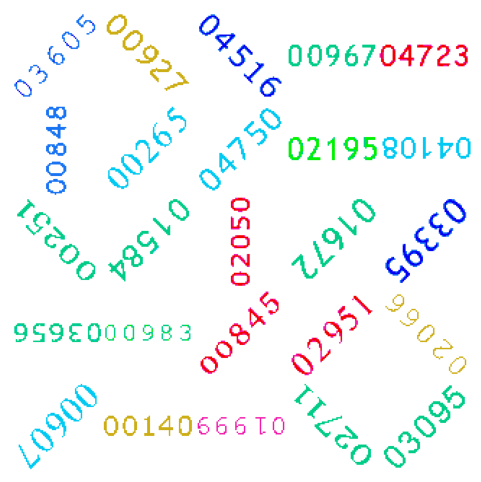

In [16]:
import torch, numpy as np, matplotlib.pyplot as plt
OUT_PT = "exports/train_96x96.pt"
blob = torch.load(OUT_PT, map_location="cpu")
imgs = blob["images"]        # [N,H,W] uint8
pal  = blob["palette"]       # [K,3] uint8

N = min(25, imgs.shape[0])
sel = list(range(N))
grid = np.zeros((5*imgs.shape[1], 5*imgs.shape[2], 3), dtype=np.uint8)

for k, i in enumerate(sel):
    r, c = divmod(k, 5)
    rgb = pal[imgs[i].long()].numpy()  # [H,W,3] uint8
    H, W = rgb.shape[:2]
    grid[r*H:(r+1)*H, c*W:(c+1)*W] = rgb

plt.figure(figsize=(6,6))
plt.imshow(grid)
plt.axis("off")
plt.show()

In [17]:
# Recorremos 'indices' y guardamos metadatos para analizar
import math, numpy as np
from collections import Counter

def _norm_font_basename(path_or_name: str) -> str:
    import os
    b = os.path.basename(path_or_name or "")
    b = os.path.splitext(b)[0]
    return b.lower().replace(" ", "").replace("_", "").replace("-", "")

labels_arr = []
rot_arr    = []
scale_arr  = []
digits_len = []
colors_rgb = []    # color del primer dígito (aprox nominal)
fonts_bn   = []    # basename normalizado

for i, ds_idx in tqdm(enumerate(indices), total=len(indices)):
    ex = ds_pool[ds_idx]
    labels_arr.append(int(ex["label"]))
    m = ex["meta"]
    rot_arr.append(float(m.get("rotation_deg", 0.0)))
    ds = m.get("digits", [])
    digits_len.append(len(ds))
    pd = m.get("per_digit", [])
    if pd:
        scale_arr.append(float(pd[0].get("scale", 1.0)))
        colors_rgb.append(tuple(pd[0].get("color", (0,0,0))))
        fonts_bn.append(_norm_font_basename(pd[0].get("font_path","")))
    else:
        scale_arr.append(1.0)
        colors_rgb.append((0,0,0))
        fonts_bn.append("")

labels_arr = np.array(labels_arr, dtype=np.int32)
rot_arr    = np.array(rot_arr, dtype=np.float32)
scale_arr  = np.array(scale_arr, dtype=np.float32)
digits_len = np.array(digits_len, dtype=np.int32)

print("Muestras:", len(indices))
print("Labels únicos:", len(np.unique(labels_arr)))
dup_rate = 1.0 - (len(np.unique(labels_arr)) / len(labels_arr))
print(f"Duplicación aproximada de labels: {dup_rate*100:.2f}%")

  0%|          | 0/1000000 [00:00<?, ?it/s]

Muestras: 1000000
Labels únicos: 5000
Duplicación aproximada de labels: 99.50%


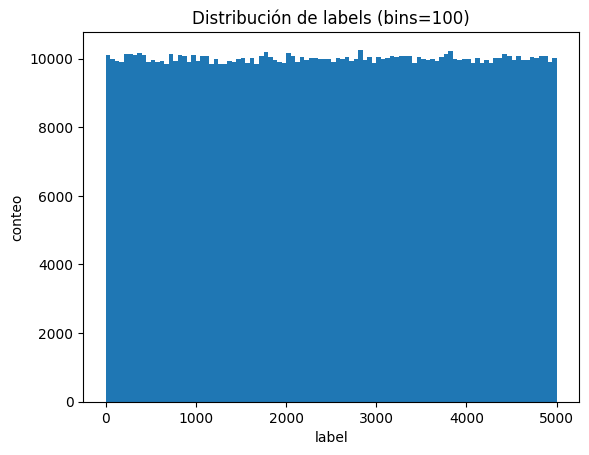

In [18]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(labels_arr, bins=100)
plt.title("Distribución de labels (bins=100)")
plt.xlabel("label")
plt.ylabel("conteo")
plt.show()

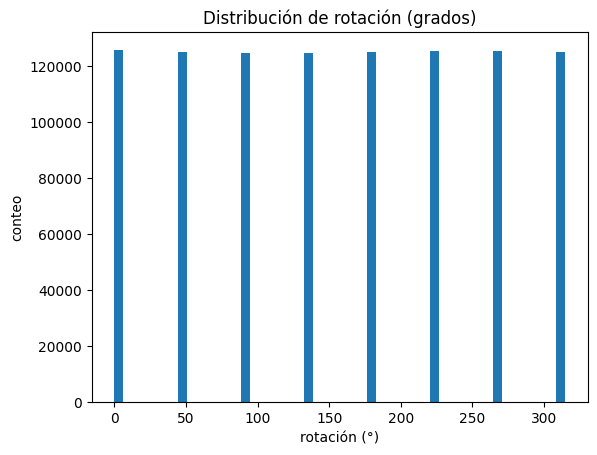

In [19]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(rot_arr, bins=50)
plt.title("Distribución de rotación (grados)")
plt.xlabel("rotación (°)")
plt.ylabel("conteo")
plt.show()

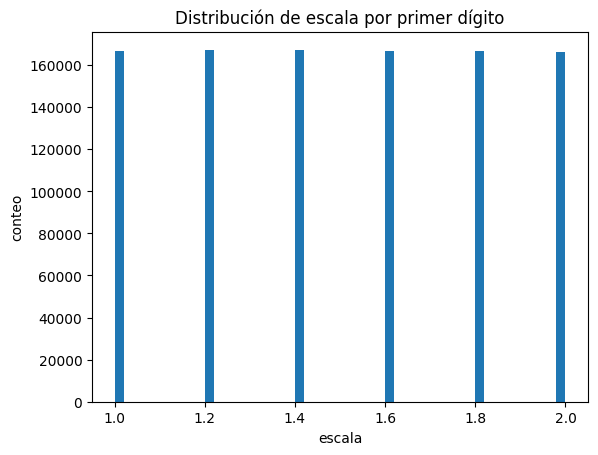

In [20]:
import matplotlib.pyplot as plt
plt.figure()
plt.hist(scale_arr, bins=50)
plt.title("Distribución de escala por primer dígito")
plt.xlabel("escala")
plt.ylabel("conteo")
plt.show()

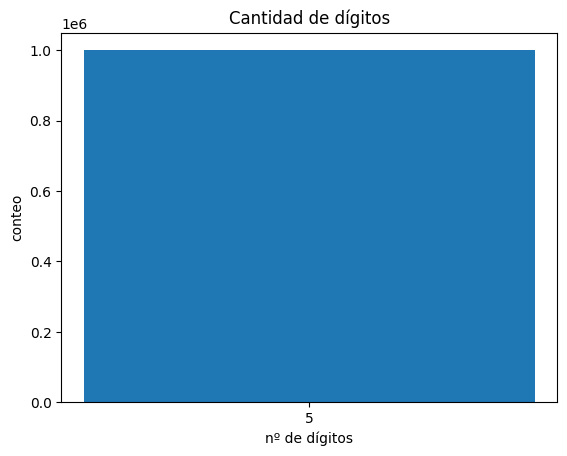

In [21]:
from collections import Counter
cnt = Counter(digits_len.tolist())
xs = sorted(cnt.keys())
ys = [cnt[x] for x in xs]

import matplotlib.pyplot as plt
plt.figure()
plt.bar([str(x) for x in xs], ys)
plt.title("Cantidad de dígitos")
plt.xlabel("nº de dígitos")
plt.ylabel("conteo")
plt.show()

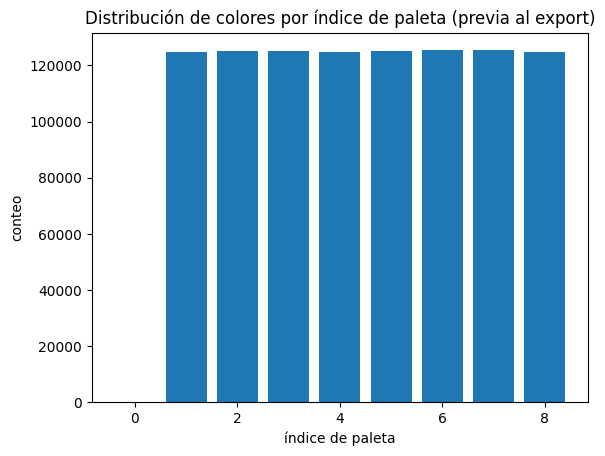

In [22]:
# Distribución de colores: si hay PALETTE mapeamos al índice más cercano;
# si no, mostramos histograma de tonos (HSV).
import matplotlib.pyplot as plt, numpy as np

def nearest_palette_index(rgb, palette):
    r,g,b = rgb
    best = 10**9; best_j = 0
    for j,(R,G,B) in enumerate(palette):
        d = (R-r)*(R-r) + (G-g)*(G-g) + (B-b)*(B-b)
        if d < best:
            best, best_j = d, j
    return best_j

if "PALETTE" in globals():
    col_idx = np.array([nearest_palette_index(c, PALETTE) for c in colors_rgb], dtype=np.int32)
    K = len(PALETTE)
    counts = [(col_idx == k).sum() for k in range(K)]
    plt.figure()
    plt.bar(range(K), counts)
    plt.title("Distribución de colores por índice de paleta (previa al export)")
    plt.xlabel("índice de paleta")
    plt.ylabel("conteo")
    plt.show()
else:
    import colorsys
    hues = []
    for (r,g,b) in colors_rgb:
        h,s,v = colorsys.rgb_to_hsv(r/255.0, g/255.0, b/255.0)
        hues.append(h)
    hues = np.array(hues, dtype=np.float32)
    plt.figure()
    plt.hist(hues, bins=24)
    plt.title("Distribución de tonos (HSV) (previa al export)")
    plt.xlabel("hue")
    plt.ylabel("conteo")
    plt.show()

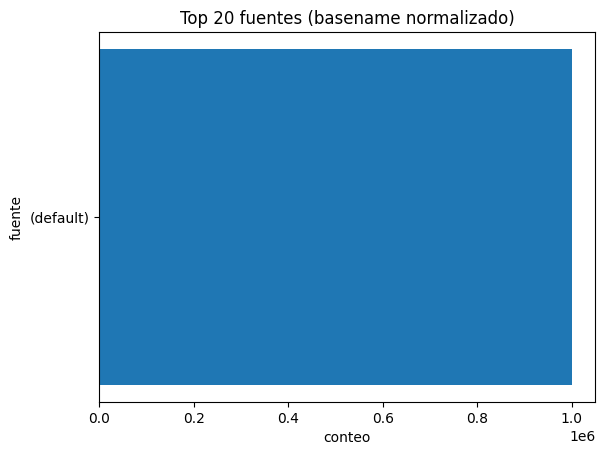

In [23]:
from collections import Counter
import matplotlib.pyplot as plt

cnt = Counter(fonts_bn)
items = cnt.most_common(20)
names = [k if k else "(default)" for k,_ in items]
vals  = [v for _,v in items]

plt.figure()
plt.barh(range(len(items)), vals)
plt.yticks(range(len(items)), names)
plt.title("Top 20 fuentes (basename normalizado)")
plt.xlabel("conteo")
plt.ylabel("fuente")
plt.gca().invert_yaxis()
plt.show()

## TEST_OOD: Number

In [8]:
# === Parámetros ===
DS_PATH = "dynamic_numbers_dataset.py"  # Ruta a tu DynamicNumbersDataset
OUT_PT  = "exports/test_number_64x64.pt"      # Salida .pt monolítica
N_SAMPLES = 100000                                                            # Tamaño del subset a exportar
CHUNK_SIZE = 50000                                                           # Lote de export (ajusta a tu IO)
SEED = 123

In [9]:
# === Crear dataset de origen (pool) ===
# Ajusta cualquier hiper-parámetro a tu configuración real.
LABELS = list(range(5_000, 10_000))
R_train = [0, 45, 90, 135, 180, 225, 270, 315]
S_train = [ 1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# Paleta de 8 colores bien separados (usa los tuyos si prefieres)
C_train = palette_perceptual_farthest(8)
F_ID = ["Arial.ttf","Georgia.ttf","Verdana.ttf","Times_New_Roman.ttf","Trebuchet_MS","Courier_New.ttf","Comic_Sans_MS.ttf"]
POOL_LEN = len(LABELS)*len(R_train)*len(S_train)*len(C_train)*len(F_ID) # All combinations of latent factors
ds_pool = DynamicNumbersDataset(
    length=POOL_LEN,
    fonts_dir = "/usr/share/fonts/truetype/msttcorefonts",
    font_paths=".",
    image_size=64, fixed_width_5=True,
    enumerate_numbers=True,                   # facilita balance por número
    min_value=min(LABELS), max_value=max(LABELS),
    rotation_values=R_train,
    per_digit_scale_values=S_train,
    per_digit_color_values=C_train,
    restrict_font_basenames=F_ID,
    require_restricted_fonts=True,
    tie_digits_font=True,
    tie_digits_scale=True,
    tie_digits_color=True,
    seed=123,
    allow_repeat_fonts=False
)
print("image_size:", ds_pool.image_size)

image_size: 64


In [10]:
# === Elegir N_SAMPLES índices (reproducible) ===
import random
rng = random.Random(SEED)
indices = list(range(len(ds_pool)))
rng.shuffle(indices)
indices = indices[:N_SAMPLES]
len(indices)

100000

In [11]:
# === Ejecutar export ===

BG = tuple(int(x) for x in ds_pool.background)  # p.ej. (255,255,255)

# Construye paleta: blanco de fondo en 0, y luego K-1 colores (sin blanco)
PALETTE = [BG] + C_train
pal_img = make_pil_palette_image(PALETTE)

summary = export_subset_to_single_pt(
    ds=ds_pool,
    indices=indices,
    out_path=OUT_PT,
    palette_rgb=PALETTE,
    pal_img=pal_img,
    chunk_size=CHUNK_SIZE,
    tmp_dir=None,
    keep_memmaps=False,
    store_meta_jsonl=True,
)
summary

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

/workspace1/asoto/araymond/datasets/dynamic_numbers_dataset.py:929: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  tensor = torch.from_numpy(arr).permute(2,0,1).float().div(255.0)
/tmp/ipykernel_732292/88229540.py:119: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr, mode="RGB")


  0%|          | 0/50000 [00:00<?, ?it/s]

{'out_path': 'exports/test_number_64x64.pt',
 'count': 100000,
 'palette_size': 9,
 'font_vocab_size': 7}

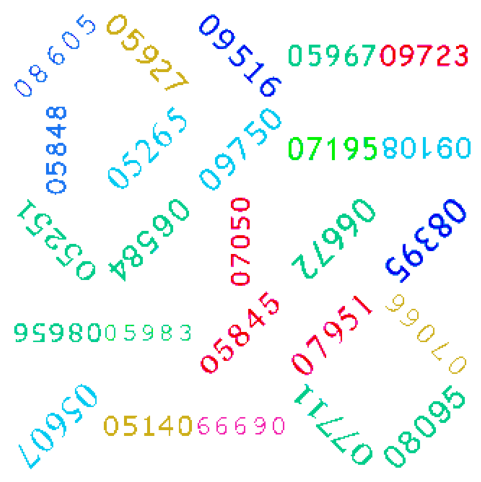

In [12]:
sample_images_from_file(OUT_PT)

## Test OOD - Scale

In [13]:
# === Parámetros ===
DS_PATH = "dynamic_numbers_dataset.py"  # Ruta a tu DynamicNumbersDataset
OUT_PT  = "exports/test_scale_64x64.pt"      # Salida .pt monolítica
N_SAMPLES = 100000                                                            # Tamaño del subset a exportar
CHUNK_SIZE = 50000                                                           # Lote de export (ajusta a tu IO)
SEED = 123

In [14]:
# === Crear dataset de origen (pool) ===
# Ajusta cualquier hiper-parámetro a tu configuración real.
LABELS = list(range(0, 5_000))
R_train = [0, 45, 90, 135, 180, 225, 270, 315]
S_train = [0.8, 0.9, 2.1, 2.2]
# Paleta de 8 colores bien separados (usa los tuyos si prefieres)
C_train = palette_perceptual_farthest(8)
F_ID = ["Arial.ttf","Georgia.ttf","Verdana.ttf","Times_New_Roman.ttf","Trebuchet_MS","Courier_New.ttf","Comic_Sans_MS.ttf"]
POOL_LEN = len(LABELS)*len(R_train)*len(S_train)*len(C_train)*len(F_ID) # All combinations of latent factors
ds_pool = DynamicNumbersDataset(
    length=POOL_LEN,
    fonts_dir = "/usr/share/fonts/truetype/msttcorefonts",
    font_paths=".",
    image_size=64, fixed_width_5=True,
    enumerate_numbers=True,                   # facilita balance por número
    min_value=min(LABELS), max_value=max(LABELS),
    rotation_values=R_train,
    per_digit_scale_values=S_train,
    per_digit_color_values=C_train,
    restrict_font_basenames=F_ID,
    require_restricted_fonts=True,
    tie_digits_font=True,
    tie_digits_scale=True,
    tie_digits_color=True,
    seed=123,
    allow_repeat_fonts=False
)
print("image_size:", ds_pool.image_size)

image_size: 64


In [15]:
# === Elegir N_SAMPLES índices (reproducible) ===
import random
rng = random.Random(SEED)
indices = list(range(len(ds_pool)))
rng.shuffle(indices)
indices = indices[:N_SAMPLES]
len(indices)

100000

In [16]:
# === Ejecutar export ===

BG = tuple(int(x) for x in ds_pool.background)  # p.ej. (255,255,255)

# Construye paleta: blanco de fondo en 0, y luego K-1 colores (sin blanco)
PALETTE = [BG] + C_train
pal_img = make_pil_palette_image(PALETTE)

summary = export_subset_to_single_pt(
    ds=ds_pool,
    indices=indices,
    out_path=OUT_PT,
    palette_rgb=PALETTE,
    pal_img=pal_img,
    chunk_size=CHUNK_SIZE,
    tmp_dir=None,
    keep_memmaps=False,
    store_meta_jsonl=True,
)
summary

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_732292/88229540.py:119: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr, mode="RGB")


  0%|          | 0/50000 [00:00<?, ?it/s]

{'out_path': 'exports/test_scale_64x64.pt',
 'count': 100000,
 'palette_size': 9,
 'font_vocab_size': 7}

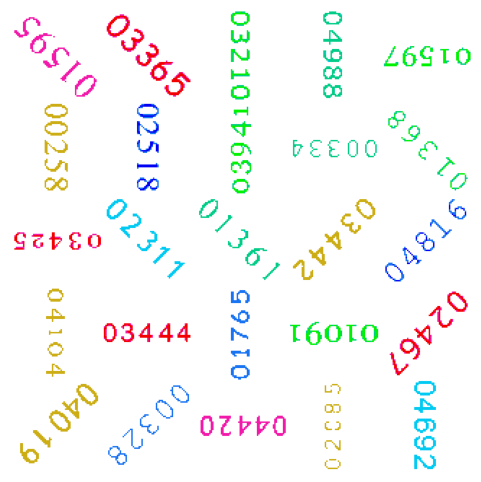

In [17]:
sample_images_from_file(OUT_PT)

## Test OOD - Rotation

In [18]:
# === Parámetros ===
DS_PATH = "dynamic_numbers_dataset.py"  # Ruta a tu DynamicNumbersDataset
OUT_PT  = "exports/test_rotation_64x64.pt"      # Salida .pt monolítica
N_SAMPLES = 100000                                                            # Tamaño del subset a exportar
CHUNK_SIZE = 50000                                                           # Lote de export (ajusta a tu IO)
SEED = 123

In [19]:
# === Crear dataset de origen (pool) ===
# Ajusta cualquier hiper-parámetro a tu configuración real.
LABELS = list(range(0, 5_000))
R_train = [22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5]
S_train = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# Paleta de 8 colores bien separados (usa los tuyos si prefieres)
C_train = palette_perceptual_farthest(8)
F_ID = ["Arial.ttf","Georgia.ttf","Verdana.ttf","Times_New_Roman.ttf","Trebuchet_MS","Courier_New.ttf","Comic_Sans_MS.ttf"]
POOL_LEN = len(LABELS)*len(R_train)*len(S_train)*len(C_train)*len(F_ID) # All combinations of latent factors
ds_pool = DynamicNumbersDataset(
    length=POOL_LEN,
    fonts_dir = "/usr/share/fonts/truetype/msttcorefonts",
    font_paths=".",
    image_size=64, fixed_width_5=True,
    enumerate_numbers=True,                   # facilita balance por número
    min_value=min(LABELS), max_value=max(LABELS),
    rotation_values=R_train,
    per_digit_scale_values=S_train,
    per_digit_color_values=C_train,
    restrict_font_basenames=F_ID,
    require_restricted_fonts=True,
    tie_digits_font=True,
    tie_digits_scale=True,
    tie_digits_color=True,
    seed=123,
    allow_repeat_fonts=False
)
print("image_size:", ds_pool.image_size)

image_size: 64


In [20]:
# === Elegir N_SAMPLES índices (reproducible) ===
import random
rng = random.Random(SEED)
indices = list(range(len(ds_pool)))
rng.shuffle(indices)
indices = indices[:N_SAMPLES]
len(indices)

100000

In [21]:
BG = tuple(int(x) for x in ds_pool.background)  # p.ej. (255,255,255)

# Construye paleta: blanco de fondo en 0, y luego K-1 colores (sin blanco)
PALETTE = [BG] + C_train
pal_img = make_pil_palette_image(PALETTE)

summary = export_subset_to_single_pt(
    ds=ds_pool,
    indices=indices,
    out_path=OUT_PT,
    palette_rgb=PALETTE,
    pal_img=pal_img,
    chunk_size=CHUNK_SIZE,
    tmp_dir=None,
    keep_memmaps=False,
    store_meta_jsonl=True,
)
summary

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_732292/88229540.py:119: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr, mode="RGB")


  0%|          | 0/50000 [00:00<?, ?it/s]

{'out_path': 'exports/test_rotation_64x64.pt',
 'count': 100000,
 'palette_size': 9,
 'font_vocab_size': 7}

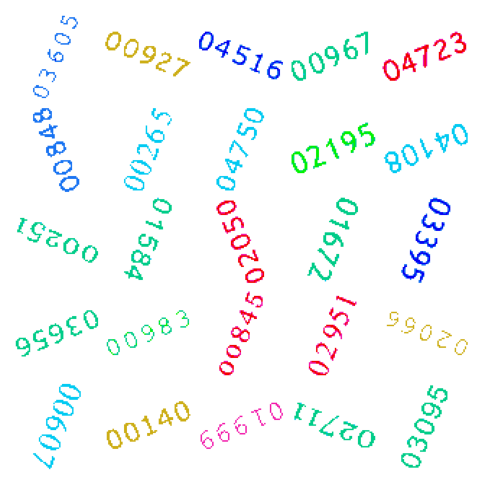

In [24]:
sample_images_from_file(OUT_PT)

## Test OOD - Font

In [25]:
# === Parámetros ===
DS_PATH = "dynamic_numbers_dataset.py"  # Ruta a tu DynamicNumbersDataset
OUT_PT  = "exports/test_font_64x64.pt"      # Salida .pt monolítica
N_SAMPLES = 100000                                                            # Tamaño del subset a exportar
CHUNK_SIZE = 50000                                                           # Lote de export (ajusta a tu IO)
SEED = 123

In [26]:
# === Crear dataset de origen (pool) ===
# Ajusta cualquier hiper-parámetro a tu configuración real.
LABELS = list(range(0, 5_000))
R_train = [0, 45, 90, 135, 180, 225, 270, 315]
S_train = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# Paleta de 8 colores bien separados (usa los tuyos si prefieres)
C_train = palette_perceptual_farthest(8)
F_ID = ["Impact.ttf"]
POOL_LEN = len(LABELS)*len(R_train)*len(S_train)*len(C_train)*len(F_ID) # All combinations of latent factors
ds_pool = DynamicNumbersDataset(
    length=POOL_LEN,
    fonts_dir = "/usr/share/fonts/truetype/msttcorefonts",
    font_paths=".",
    image_size=64, fixed_width_5=True,
    enumerate_numbers=True,                   # facilita balance por número
    min_value=min(LABELS), max_value=max(LABELS),
    rotation_values=R_train,
    per_digit_scale_values=S_train,
    per_digit_color_values=C_train,
    restrict_font_basenames=F_ID,
    require_restricted_fonts=True,
    tie_digits_font=True,
    tie_digits_scale=True,
    tie_digits_color=True,
    seed=123,
    allow_repeat_fonts=False
)
print("image_size:", ds_pool.image_size)

image_size: 64


In [27]:
# === Elegir N_SAMPLES índices (reproducible) ===
import random
rng = random.Random(SEED)
indices = list(range(len(ds_pool)))
rng.shuffle(indices)
indices = indices[:N_SAMPLES]
len(indices)

100000

In [28]:
BG = tuple(int(x) for x in ds_pool.background)  # p.ej. (255,255,255)

# Construye paleta: blanco de fondo en 0, y luego K-1 colores (sin blanco)
PALETTE = [BG] + C_train
pal_img = make_pil_palette_image(PALETTE)
summary = export_subset_to_single_pt(
    ds=ds_pool,
    indices=indices,
    out_path=OUT_PT,
    palette_rgb=PALETTE,
    pal_img=pal_img,
    chunk_size=CHUNK_SIZE,
    tmp_dir=None,
    keep_memmaps=False,
    store_meta_jsonl=True,
)
summary

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_732292/3033557823.py:120: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr, mode="RGB")


  0%|          | 0/50000 [00:00<?, ?it/s]

{'out_path': 'exports/test_font_64x64.pt',
 'count': 100000,
 'palette_size': 9,
 'font_vocab_size': 1}

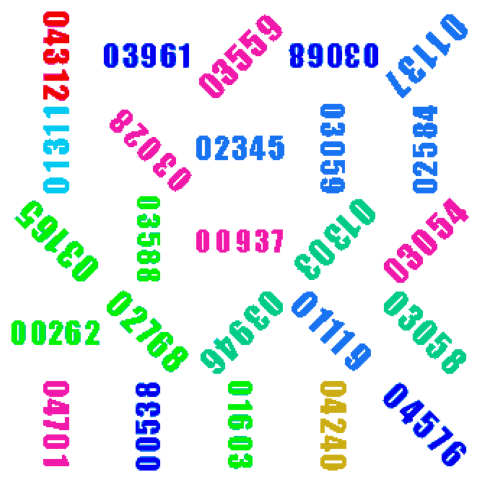

In [29]:
sample_images_from_file(OUT_PT)

## Test OOD - Color

In [20]:
# === Parámetros ===
DS_PATH = "dynamic_numbers_dataset.py"  # Ruta a tu DynamicNumbersDataset
OUT_PT  = "exports/test_color_64x64.pt"      # Salida .pt monolítica
N_SAMPLES = 100000                                                            # Tamaño del subset a exportar
CHUNK_SIZE = 50000                                                           # Lote de export (ajusta a tu IO)
SEED = 123

In [21]:
# === Crear dataset de origen (pool) ===
# Ajusta cualquier hiper-parámetro a tu configuración real.
LABELS = list(range(0, 5_000))
R_train = [0, 45, 90, 135, 180, 225, 270, 315]
S_train = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0]
# Paleta de 8 colores bien separados (usa los tuyos si prefieres)
#C_train = [palette_perceptual_farthest(9)[-1]]
C_train = [(122,122,122)] # We force a gray
F_ID = ["Arial.ttf","Georgia.ttf","Verdana.ttf","Times_New_Roman.ttf","Trebuchet_MS","Courier_New.ttf","Comic_Sans_MS.ttf"]
POOL_LEN = len(LABELS)*len(R_train)*len(C_train)*len(S_train)*len(F_ID) # All combinations of latent factors
pal_img = make_pil_palette_image(PALETTE)
ds_pool = DynamicNumbersDataset(
    length=POOL_LEN,
    fonts_dir = "/usr/share/fonts/truetype/msttcorefonts",
    font_paths=".",
    image_size=64, fixed_width_5=True,
    enumerate_numbers=True,                   # facilita balance por número
    min_value=min(LABELS), max_value=max(LABELS),
    rotation_values=R_train,
    per_digit_scale_values=S_train,
    per_digit_color_values=C_train,
    restrict_font_basenames=F_ID,
    require_restricted_fonts=True,
    tie_digits_font=True,
    tie_digits_scale=True,
    tie_digits_color=True,
    seed=123,
    allow_repeat_fonts=False
)
print("image_size:", ds_pool.image_size)

image_size: 64


In [22]:
# === Elegir N_SAMPLES índices (reproducible) ===
import random
rng = random.Random(SEED)
indices = list(range(len(ds_pool)))
rng.shuffle(indices)
indices = indices[:N_SAMPLES]
len(indices)

100000

In [23]:
BG = tuple(int(x) for x in ds_pool.background)  # p.ej. (255,255,255)

# Construye paleta: blanco de fondo en 0, y luego K-1 colores (sin blanco)
PALETTE = [BG] + C_train

summary = export_subset_to_single_pt(
    ds=ds_pool,
    indices=indices,
    out_path=OUT_PT,
    palette_rgb=PALETTE,
    pal_img=pal_img,
    chunk_size=CHUNK_SIZE,
    tmp_dir=None,
    keep_memmaps=False,
    store_meta_jsonl=True,
)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_417457/3033557823.py:120: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(arr, mode="RGB")


  0%|          | 0/50000 [00:00<?, ?it/s]

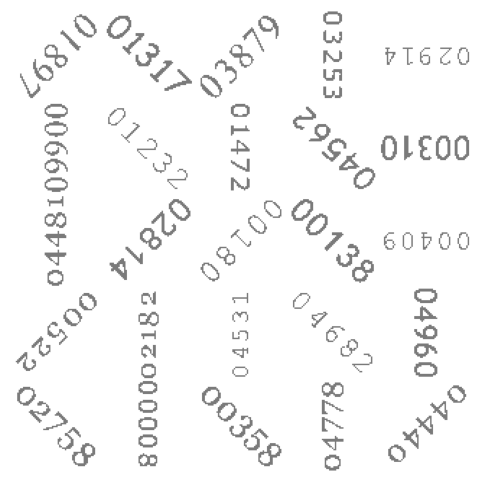

In [24]:
sample_images_from_file(OUT_PT)

In [15]:
C_train

[(206, 24, 242)]